[Documentation of LBMPy](https://mybinder.org/v2/gh/mabau/lbmpy/master?filepath=doc%2Fnotebooks)

[Enhanced MRT](https://journals.aps.org/pre/pdf/10.1103/PhysRevE.102.023307)

[MRT Theory](https://journals.aps.org/pre/pdf/10.1103/PhysRevE.61.6546)

1. [Analysis](#FHD-LBMeX-implementation-analysis)

# FHD LBMeX implementation analysis

In [67]:
import sympy.abc as w
from lbmpy.session import *
from lbmpy.chapman_enskog import ChapmanEnskogAnalysis
from lbmpy.methods.creationfunctions import create_from_equilibrium
import numpy as np
from lbmpy.methods import mrt_orthogonal_modes_literature
from lbmpy.stencils import get_stencil
from lbmpy.moments import MOMENT_SYMBOLS
from lbmpy.methods import DensityVelocityComputation
from lbmpy.moments import moment_matrix, moments_up_to_component_order, exponents_to_polynomial_representations

d3q19 = LBStencil(Stencil.D3Q19)

rho = w.rho
u = sp.symbols('u_0, u_1, u_2')
               
phi = w.phi
psi = w.psi

pb, cs = sp.symbols('p_b, c_s')
deviation = False
krr = sp.Symbol(r"k_{\rho\rho}")
kpp = sp.Symbol('k_{\phi\phi}')
kss = sp.Symbol('k_{\psi\psi}')

x, y, z = sp.symbols('x, y, z')

In [68]:
v = np.array(list(d3q19))

zero = sp.core.sympify(0)
one = sp.core.sympify(1)

(x, y) = v.shape

sympy_v = np.zeros_like(v, dtype = object)

for i in range(x):
    for j in range(y):
        if v[i, j] == 0:
            sympy_v[i, j] = zero
        elif v[i, j] == 1:
            sympy_v[i, j] = one
        elif v[i, j] == -1:
            sympy_v[i, j] = -one

v = sympy_v

In [69]:
zero = sp.core.sympify(0)
five36 = sp.Rational(5,36)
one6 = sp.Rational(1,6)
one9 = sp.Rational(1,9)
one12 = sp.Rational(1,12)
one36 = sp.Rational(1,36)
one72 = sp.Rational(1,72)

w_i = np.zeros(19, dtype = object)
w_i[0] = sp.Rational(1,3); w_i[1:7] = sp.Rational(1,18); w_i[7:] = sp.Rational(1,36)

w_xx = np.zeros_like(w_i)
w_yy = np.zeros_like(w_i)
w_zz = np.zeros_like(w_i)

w_xy = np.zeros_like(w_i)
w_zx = np.zeros_like(w_i)
w_yz = np.zeros_like(w_i)

w_xx[1:3] = w_yy[3:5] = w_zz[5:7] = five36
w_xx[3:7] = w_yy[[1, 2, 5, 6]] = w_zz[1:5] = -one9
w_xx[7:11] = w_xx[15:] = w_yy[7:15] = w_zz[11:] = -one72
w_xx[11:15] = w_yy[15:] = w_zz[7:11] = one36

w_xy[1:7] = w_yz[1:7] = w_zx[1:7] = zero
w_xy[[7, 10]] = w_yz[[11, 14]] = w_zx[[15, 18]] = one12
w_xy[[8, 9]] = w_yz[[12, 13]] = w_zx[[16, 17]] = -one12
w_xy[11:] = w_yz[7:11] = w_yz[15:] = w_zx[7:15] = zero

w_xx[0] = w_yy[0] = w_zz[0] = one6

w = np.array([w_xx, w_yy, w_zz, w_xy, w_yz, w_zx])
w = w.T

In [70]:
one = sp.core.sympify(1)
x, y, z = MOMENT_SYMBOLS
c2 = x**2 + y**2 + z**2
c4 = c2**2

zeroth_order = [one]
first_order = [x, y, z]
second_order = [c2 - 1, 3*x**2 - c2, y**2 - z**2, x*y, y*z, z*x]
third_order = [(3*c2 - 5)*x, (3*c2 - 5)*y, (3*c2 - 5)*z, (y**2 - z**2)*x, (z**2 - x**2)*y, (x**2 - y**2)*z]
fourth_order = [3*c4 - 6*c2 + 1, (2*c2 - 3)*(3*x**2 - c2), (2*c2 - 3)*(y**2 - z**2)]

moments = [*zeroth_order, *first_order, *second_order, *third_order, *fourth_order]

M = moment_matrix(moments, stencil=d3q19)

In [79]:
from sympy.vector import CoordSys3D, Del
C = CoordSys3D('C')
delop = Del()

f_i_eq = []

d_ab = np.identity(3)

order_parameter = [rho, phi, psi]
k_all = [krr, kpp, kss]
diff1 = [[x, x], [y, y], [z, z], [x, y], [y, z], [z, x]]
    
for i in range(19):
    term1 = sp.core.sympify(0)
    term2 = sp.core.sympify(0)
    
    term3 = sp.core.sympify(0)
    term4 = sp.core.sympify(0)
    term5 = sp.core.sympify(0)
    
    for j in range(3):
        term1 += v[i, j]*rho*u[j]/cs**2
        for k in range(3):
            term1 += rho*u[j]*u[k]*(v[i, j]*v[i, k] - cs**2*d_ab[j, k])
        
        op = order_parameter[j]
        k_curr = k_all[j]
        
        grad2 = op*k_curr*(sp.Derivative(sp.Derivative(op, x), x) + sp.Derivative(sp.Derivative(op, y), y) + sp.Derivative(sp.Derivative(op, z), z))
        term2 += grad2
        
    term1 += pb/cs**2
    term1 *= w_i[i]
    
    term2 *= -w_i[i]/cs**2
    
    for k in range(6):
        term3 += w[i, k]*sp.Derivative(rho, diff1[k][0])*sp.Derivative(rho, diff1[k][1])
    term3 *= krr/cs**2
    
    for k in range(6):
        term4 += w[i, k]*sp.Derivative(phi, diff1[k][0])*sp.Derivative(phi, diff1[k][1])
    term4 *= kpp/cs**2
    
    for k in range(6):
        term5 += w[i, k]*sp.Derivative(psi, diff1[k][0])*sp.Derivative(psi, diff1[k][1])
    term5 *= kss/cs**2
    
    f_i_eq.append(term1 + term2 + term3 + term4 + term5)

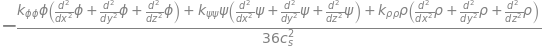

In [80]:
term2

In [81]:
equilibrium = lbmpy.equilibrium.GenericDiscreteEquilibrium(d3q19, f_i_eq, rho, u)

In [82]:
omega = sp.symbols("omega")
relaxation_rate_dict = {moment : omega for moment in moments}

cqc = DensityVelocityComputation(d3q19, True, False)

method = create_from_equilibrium(d3q19, equilibrium, cqc, relaxation_rate_dict)
method